<a href="https://colab.research.google.com/github/axel-sirota/tf-dev-nlp/blob/main/module5/TF_Developer_NLP_Module5_Demo1_Text_Generation_Character.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating Support like responses



## Setup and dataset constructions

Let's first import everything and load the dataset

In [1]:
!pip install textblob 'gensim==4.2.0' 'keras-nlp' swifter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import multiprocessing
import tensorflow as tf
import sys
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda, ELU, Conv1D, MaxPooling1D, Dropout
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras import preprocessing
from textblob import TextBlob, Word
from keras_preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Model, Input
import swifter
import keras_nlp
import numpy as np
import re
import random
import os
import pandas as pd
import gensim
import warnings
import nltk
import time

TRACE = False
embedding_dim = 256
rnn_units = 1024
epochs=5
buffer_size = 2000
# Batch size
batch_size = 256
fraction_corpus = 0.02
BATCH = True

def set_seeds_and_trace():
  os.environ['PYTHONHASHSEED'] = '0'
  np.random.seed(42)
  tf.random.set_seed(42)
  random.seed(42)
  if TRACE:
    tf.debugging.set_log_device_placement(True)

def set_session_with_gpus_and_cores():
  cores = multiprocessing.cpu_count()
  gpus = len(tf.config.list_physical_devices('GPU'))
  config = tf.compat.v1.ConfigProto( device_count = {'GPU': gpus  , 'CPU': cores} , intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  sess = tf.compat.v1.Session(config=config) 
  K.set_session(sess)

set_seeds_and_trace()
set_session_with_gpus_and_cores()
warnings.filterwarnings('ignore')
nltk.download('punkt')
textblob_tokenizer = lambda x: TextBlob(x).words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Now we will download the dataset and explore it

In [3]:
%%writefile get_data.sh
if [ ! -f twitter.csv ]; then
  wget -O twitter.csv https://www.dropbox.com/s/hjji6x6vx4wno1c/twcs.csv?dl=0
fi

Overwriting get_data.sh


In [54]:
!bash get_data.sh


Let's inspect how this intents csv looks like

In [4]:
! head twitter.csv

tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist you. We would need to get you into a private secured link to further assist.,2,3
2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,,1
3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messages and no one is responding as usual,1,4
4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so that we can further assist you. Just click ‘Message’ at the top of your profile.,3,5
5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6
6,sprintcare,False,Tue Oct 31 21:46:24 +0000 2017,"@115712 Can you please send us a private message, so that I can gain further details about your account?","5,7",8
8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",
11,s

In [5]:
def preprocess_text(text, should_join=True):
    text = ' '.join(word.lower() for word in textblob_tokenizer(text))
    text = re.sub(r"(\@\d+)", r" ", text) # remove twitter handle
    text = re.sub(r"(https\:\/\/t.co\/\w+)", r" ", text) # remove end twtter url
    text = re.sub(r"([.,!?])", r" ", text) # remove punctuation
    text = re.sub(r"[^a-zA-Z.,&!?]+", r" ", text) # only normal characters
    if should_join:
      return ' '.join(gensim.utils.simple_preprocess(text))
    else:
      return gensim.utils.simple_preprocess(text)

In [6]:
path = './twitter.csv'
twitter = pd.read_csv(path, header=0)
twitter

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0
...,...,...,...,...,...,...,...
2811769,2987947,sprintcare,False,Wed Nov 22 08:43:51 +0000 2017,"@823869 Hey, we'd be happy to look into this f...",NaN,2987948.0
2811770,2987948,823869,True,Wed Nov 22 08:35:16 +0000 2017,@115714 wtf!? I’ve been having really shitty s...,2987947,NaN
2811771,2812240,121673,True,Thu Nov 23 04:13:07 +0000 2017,@143549 @sprintcare You have to go to https://...,NaN,2812239.0
2811772,2987949,AldiUK,False,Wed Nov 22 08:31:24 +0000 2017,"@823870 Sounds delicious, Sarah! 😋 https://t.c...",NaN,2987950.0


In [7]:
twitter[twitter.inbound == False ].author_id.value_counts()

AmazonHelp        169840
AppleSupport      106860
Uber_Support       56270
SpotifyCares       43265
Delta              42253
                   ...  
JackBox              266
OfficeSupport        218
AskDSC               210
CarlsJr              196
HotelTonightCX       152
Name: author_id, Length: 108, dtype: int64

In [8]:
twitter_filtered = twitter[twitter.inbound == False ].groupby('author_id').filter(lambda x: len(x) >= 10000).sample(frac=fraction_corpus).reset_index()
twitter_filtered.author_id.value_counts()

AmazonHelp         3452
AppleSupport       2081
Uber_Support       1114
SpotifyCares        882
Delta               801
AmericanAir         759
TMobileHelp         720
Tesco               715
comcastcares        667
SouthwestAir        589
British_Airways     588
VirginTrains        556
XboxSupport         528
Ask_Spectrum        525
sprintcare          421
GWRHelp             410
AskPlayStation      406
sainsburys          404
hulu_support        404
UPSHelp             395
VerizonSupport      378
ChipotleTweets      368
ATVIAssist          358
idea_cares          308
Safaricom_Care      307
O2                  307
BofA_Help           252
ArgosHelpers        249
AskTarget           247
AskPayPal           243
AirAsiaSupport      237
SW_Help             233
MicrosoftHelps      232
AskLyft             223
marksandspencer     221
AskAmex             220
Morrisons           213
Name: author_id, dtype: int64

In [9]:
responses = twitter_filtered.reset_index(drop=True).text
responses

0        @340426 Apologies! We currently don't support ...
1        @130645 Hi, please let us know if you have a s...
2        @820651 Sure Ahmed, may we have the booking nu...
3        @223341 I'm sorry to hear that you did not rec...
4        @399801 traffic through this area to keep the ...
                               ...                        
21008    @725924 Hi Manish, we're sorry to hear about y...
21009    @354208 If you mention this to the Train Manag...
21010    @379841 Hey there! Could you DM us your accoun...
21011    @121878 Hey Miranda, can you DM me a snap of y...
21012    @714178 Our offer to take a closer look at wha...
Name: text, Length: 21013, dtype: object

In [10]:
responses[0]

"@340426 Apologies! We currently don't support off line streaming, but we'll express your interest in seeing this option in the future."

In [11]:
processed_responses = responses.swifter.apply(preprocess_text)

Pandas Apply:   0%|          | 0/21013 [00:00<?, ?it/s]

In [12]:
processed_responses[0]

'apologies we currently do support off line streaming but we ll express your interest in seeing this option in the future'

In [13]:
vocab = set()

for ix, response in processed_responses.iteritems():
    vocab.update(set(str(response)))
vocab = sorted(vocab)


In [14]:
print(f'{len(vocab)} unique characters')

27 unique characters


In [15]:

ids_from_chars = preprocessing.StringLookup(vocabulary=list(vocab), mask_token=None)


In [16]:

chars_from_ids = preprocessing.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)


In [17]:

def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [18]:
ids = ids_from_chars(tf.strings.unicode_split('Only you can prevent forest fires', input_encoding='UTF-8'))
ids

<tf.Tensor: shape=(33,), dtype=int64, numpy=
array([ 0, 15, 13, 26,  1, 26, 16, 22,  1,  4,  2, 15,  1, 17, 19,  6, 23,
        6, 15, 21,  1,  7, 16, 19,  6, 20, 21,  1,  7, 10, 19,  6, 20])>

In [19]:
text_from_ids(ids)

<tf.Tensor: shape=(), dtype=string, numpy=b'[UNK]nly you can prevent forest fires'>

## Creating the corpus and tokenizing

In [20]:
def get_maximum_review_length(srs):
    maximum = 0
    for response in srs:
        candidate = len(preprocess_text(response, should_join=True))
        if candidate > maximum:
            maximum = candidate
    return maximum


maximum = get_maximum_review_length(processed_responses)
maximum

288

In [21]:
X_train, X_test = train_test_split(processed_responses, test_size=0.2, random_state=42)
X_train

6108     am sorry to hear about that please send me dm ...
11343    here to help send us note at https co zue dj y...
18736    as you ve submitted your details already you m...
15362    just checking this for you now will be back in...
8487     there should be chat available as well if you ...
                               ...                        
11284    sorry for any frustration without revealing ac...
11964    the resolution provided by our specialist team...
5390     sorry sean we do have any details regarding th...
860      can you please follow this link for me so can ...
15795    appreciate this must be frustrating and like t...
Name: text, Length: 16810, dtype: object

In [22]:
def pad_sequence_of_tokens(x, maxlen, unk_token='[UNK]'):
  if len(x)<maxlen:
    x.extend([unk_token]*(maxlen-len(x)))
  return x

In [23]:
''.join(pad_sequence_of_tokens(list('I love ice cream'), maxlen=50))

'I love ice cream[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]'

In [24]:
ids_from_chars(pad_sequence_of_tokens(list('I love ice cream'), maxlen=50))

<tf.Tensor: shape=(50,), dtype=int64, numpy=
array([ 0,  1, 13, 16, 23,  6,  1, 10,  4,  6,  1,  4, 19,  6,  2, 14,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])>

In [25]:

def get_ids_tensor(srs):
  
  processed = srs.swifter.apply(lambda x: pad_sequence_of_tokens(list(preprocess_text(x, should_join=True)), maxlen=maximum)).to_list()
  return tf.squeeze(tf.constant(pad_sequences(ids_from_chars(processed), maxlen=maximum, padding='post'), dtype='int32'))


In [26]:
all_ids = get_ids_tensor(srs=X_train.reset_index(drop=True))
all_ids

Pandas Apply:   0%|          | 0/16810 [00:00<?, ?it/s]

<tf.Tensor: shape=(16810, 288), dtype=int32, numpy=
array([[ 2, 14,  1, ...,  0,  0,  0],
       [ 9,  6, 19, ...,  0,  0,  0],
       [ 2, 20,  1, ...,  0,  0,  0],
       ...,
       [20, 16, 19, ...,  0,  0,  0],
       [ 4,  2, 15, ...,  0,  0,  0],
       [ 2, 17, 17, ...,  0,  0,  0]], dtype=int32)>

In [27]:
all_ids.shape

TensorShape([16810, 288])

In [28]:
ids_from_chars(tf.strings.unicode_split(X_train.iloc[0], 'UTF-8'))


<tf.Tensor: shape=(137,), dtype=int64, numpy=
array([ 2, 14,  1, 20, 16, 19, 19, 26,  1, 21, 16,  1,  9,  6,  2, 19,  1,
        2,  3, 16, 22, 21,  1, 21,  9,  2, 21,  1, 17, 13,  6,  2, 20,  6,
        1, 20,  6, 15,  5,  1, 14,  6,  1,  5, 14,  1, 24, 10, 21,  9,  1,
       26, 16, 22, 19,  1,  7, 22, 13, 13,  1, 15,  2, 14,  6,  1,  2,  5,
        5, 19,  6, 20, 20,  1,  2, 15,  5,  1,  2,  4,  4, 16, 22, 15, 21,
        1, 15, 22, 14,  3,  6, 19,  1, 24, 10, 13, 13,  1,  3,  6,  1,  9,
        2, 17, 17, 26,  1, 21, 16,  1,  9,  6, 13, 17,  1, 19,  6, 20, 16,
       13, 23,  6,  1, 21,  9, 10, 20,  1, 21,  9,  2, 15, 12, 20,  1, 19,
       16])>

In [29]:
test_all_ids = get_ids_tensor(srs=X_test)

Pandas Apply:   0%|          | 0/4203 [00:00<?, ?it/s]

In [30]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)
test_ids_dataset = tf.data.Dataset.from_tensor_slices(test_all_ids)

In [31]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [32]:
dataset = ids_dataset.map(split_input_target)
test_dataset = test_ids_dataset.map(split_input_target)

In [33]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'am sorry to hear about that please send me dm with your full name address and account number will be happy to help resolve this thanks ro[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]'
Target: b'm sorry to hear about that please send me dm with your full name address and account number

In [34]:

shuffled_batched_dataset = (
    dataset
    .shuffle(buffer_size)
    .batch(batch_size=batch_size, drop_remainder=True)
)
shuffled_batched_test_dataset = (
    test_dataset
    .shuffle(buffer_size)
    .batch(batch_size=batch_size, drop_remainder=True)
)

## Doing the train_test split and defining model

In [36]:
class CustomerSupportGenerator(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.rnn = tf.keras.layers.GRU(rnn_units,
                                   activation='tanh',
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.rnn.get_initial_state(x)
    x, states = self.rnn(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x
  
  def build_graph(self, maxlen):
    x = Input(shape=(maxlen, ))
    return Model(inputs=x, outputs=self.call(x))

In [37]:
model = CustomerSupportGenerator(
    # Be sure the vocabulary size matches the `StringLookup` layers.
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [40]:
model.summary()

ValueError: ignored

In [44]:
for input_example_batch, target_example_batch in shuffled_batched_dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(input_example_batch.shape, "# Input: (batch_size, sequence_length)")
    print(example_batch_predictions.shape, "# Output: (batch_size, sequence_length, vocab_size)")

(256, 287) # Input: (batch_size, sequence_length)
(256, 287, 28) # Output: (batch_size, sequence_length, vocab_size)


In [45]:
model.summary()

Model: "customer_support_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  7168      
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense (Dense)               multiple                  28700     
                                                                 
Total params: 3,974,172
Trainable params: 3,974,172
Non-trainable params: 0
_________________________________________________________________


In [46]:
model.build_graph(maxlen=maximum)  # Notice the change in outputs!

In [47]:
model.summary()

Model: "customer_support_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 288, 256)          7168      
                                                                 
 gru (GRU)                   [(None, 288, 1024),       3938304   
                              (None, 1024)]                      
                                                                 
 dense (Dense)               (None, 288, 28)           28700     
                                                                 
Total params: 3,974,172
Trainable params: 3,974,172
Non-trainable params: 0
_________________________________________________________________


In [48]:
perplexity = keras_nlp.metrics.Perplexity(from_logits=True, name='perplexity', mask_token_id=0)
model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[perplexity])


Notice the non-trainable parameters

In [49]:
history = model.fit(shuffled_batched_dataset, epochs=epochs, workers=5, validation_data=shuffled_batched_test_dataset)


Epoch 1/5
65/65 [==============================] - 38s 552ms/step - loss: 1.4390 - perplexity: 33.7689 - val_loss: 1.0287 - val_perplexity: 17.3496
Epoch 2/5
65/65 [==============================] - 38s 578ms/step - loss: 0.9833 - perplexity: 15.5201 - val_loss: 0.9273 - val_perplexity: 13.1814
Epoch 3/5
65/65 [==============================] - 38s 587ms/step - loss: 0.8772 - perplexity: 11.5419 - val_loss: 0.8344 - val_perplexity: 10.1160
Epoch 4/5
65/65 [==============================] - 38s 581ms/step - loss: 0.8023 - perplexity: 9.3653 - val_loss: 0.7757 - val_perplexity: 8.6173
Epoch 5/5
65/65 [==============================] - 38s 584ms/step - loss: 0.7446 - perplexity: 7.9834 - val_loss: 0.7166 - val_perplexity: 7.3144


## Some plots

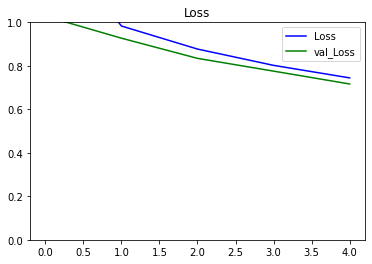

In [41]:
import matplotlib.pyplot as plt
# function for plotting loss
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric,color='blue',label=metric_name)
    if val_metric is not None: plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend(loc="upper right")

# plot loss history
plot_metrics(history.history['loss'], history.history['val_loss'], "Loss", "Loss", ylim=1.0)


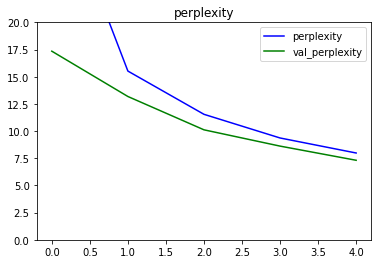

In [42]:
plot_metrics(history.history['perplexity'], val_metric=history.history['val_perplexity'], metric_name="perplexity", title="perplexity", ylim=20.0)


In [43]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [44]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)
start = time.time()
states = None
next_char = tf.constant(['Hi! We are sorry'])
result = [next_char]

for n in range(250):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor([b'Hi! We are sorryggpqxzjgzzxqkkzzpqfqwzgzquvbjz qkqx dmjmpbvukvmpgmuqufrshat adid you fporrathe soun on thes de wevl you heley ta lele sores wo hitp your jaicole dishase hlsps co ld jx wagd jo llaqk you knes in we tlk we ll you tiy our thas dm ansimige can coront wit'], shape=(1,), dtype=string) 

________________________________________________________________________________

Run time: 1.690948724746704
